# Step 1: Import necessary libraries

In [2]:
# Step 1: Import necessary libraries
# -------------------------------
# Install dependencies
!pip install catboost shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from catboost import CatBoostClassifier, Pool
import shap
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00


# Step 2: Load and Explore the Dataset

In [3]:
# Step 2: Load and Explore the Dataset
# -------------------------------
# Load the dataset
data = pd.read_csv('Autism Behaviour Dataset.csv')

# Display first rows and dataset info
print("First 5 rows of the dataset:")
print(data.head())

print("\nDataset Info:")
print(data.info())

First 5 rows of the dataset:
   Child ID  Age  Gender Current Mood  Parent Satisfaction  Engagement Level  \
0        82    6  Female      Disgust                    2                21   
1        60    7    Male   Frustrated                    2               143   
2       298    8    Male      Neutral                    5               270   
3        70    9    Male        Happy                    4               282   
4       652    7  Female      Neutral                    5               295   

   Completed Tasks  Time Spent  Correct in First Attempt      Level  
0                8        73.6                         1   Very Low  
1                2        43.3                         4   Very Low  
2                5        55.9                         7       High  
3                7        41.7                         6  Very High  
4                9        66.6                         6       High  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 e

# Step 3: Check for Missing Values

In [4]:
# Step 3: Check for Missing Values
# -------------------------------
print("\nChecking for missing values:")
print(data.isnull().sum())


Checking for missing values:
Child ID                    0
Age                         0
Gender                      0
Current Mood                0
Parent Satisfaction         0
Engagement Level            0
Completed Tasks             0
Time Spent                  0
Correct in First Attempt    0
Level                       0
dtype: int64


# Step 4: Identify Categorical vs. Numeric Columns

In [5]:
# Step 4: Identify Categorical vs. Numeric Columns
# -------------------------------
categorical_cols = ["Gender", "Current Mood", "Level"]
numeric_cols = ["Age", "Parent Satisfaction", "Engagement Level",
               "Completed Tasks", "Time Spent", "Correct in First Attempt"]

# Step 5: Label Encode the Categorical Columns

In [6]:
# Step 5: Label Encode the Categorical Columns
# -------------------------------
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

print("\nData after Label Encoding (preview):")
print(data.head())



Data after Label Encoding (preview):
   Child ID  Age  Gender  Current Mood  Parent Satisfaction  Engagement Level  \
0        82    6       0             1                    2                21   
1        60    7       1             3                    2               143   
2       298    8       1             5                    5               270   
3        70    9       1             4                    4               282   
4       652    7       0             5                    5               295   

   Completed Tasks  Time Spent  Correct in First Attempt  Level  
0                8        73.6                         1      4  
1                2        43.3                         4      4  
2                5        55.9                         7      0  
3                7        41.7                         6      3  
4                9        66.6                         6      0  


# Step 6: Define Features (X) and Target (y)

In [7]:
# Step 6: Define Features (X) and Target (y)
# -------------------------------
# We want to predict "Level", so exclude it from features
# Also, "Child ID" is usually just an identifier, so we skip it
feature_cols = [
    "Age", "Gender", "Current Mood", "Parent Satisfaction",
    "Engagement Level", "Completed Tasks", "Time Spent",
    "Correct in First Attempt"
]
target_col = "Level"

X = data[feature_cols]
y = data[target_col]

# Step 7: Split Data into Training and Test Sets

In [8]:
# Step 7: Split Data into Training and Test Sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (640, 8)
Test set size: (160, 8)


# Step 8: Train a CatBoost Classifier

In [9]:
# Step 8: Train a CatBoost Classifier
# -------------------------------
# Identify categorical feature indices
cat_features = [X_train.columns.get_loc(col) for col in ["Gender", "Current Mood"]]

# Initialize CatBoost
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    cat_features=cat_features,
    verbose=10
)

# Fit the model
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7515625	test: 0.6375000	best: 0.6375000 (0)	total: 64.1ms	remaining: 6.35s
10:	learn: 0.9468750	test: 0.9125000	best: 0.9125000 (10)	total: 205ms	remaining: 1.66s
20:	learn: 0.9609375	test: 0.9187500	best: 0.9250000 (13)	total: 327ms	remaining: 1.23s
30:	learn: 0.9718750	test: 0.9250000	best: 0.9312500 (27)	total: 449ms	remaining: 1000ms
40:	learn: 0.9750000	test: 0.9250000	best: 0.9312500 (27)	total: 538ms	remaining: 774ms
50:	learn: 0.9812500	test: 0.9125000	best: 0.9312500 (27)	total: 650ms	remaining: 625ms
60:	learn: 0.9875000	test: 0.9125000	best: 0.9312500 (27)	total: 776ms	remaining: 496ms
70:	learn: 0.9921875	test: 0.9125000	best: 0.9312500 (27)	total: 894ms	remaining: 365ms
80:	learn: 0.9937500	test: 0.9187500	best: 0.9312500 (27)	total: 987ms	remaining: 232ms
90:	learn: 0.9937500	test: 0.9125000	best: 0.9312500 (27)	total: 1.06s	remaining: 105ms
99:	learn: 0.9953125	test: 0.9125000	best: 0.9312500 (27)	total: 1.12s	remaining: 0us

bestTest = 0.93125
bestIteration 

# Step 9: Evaluate the Model on the Test Set


Model Accuracy on Test Set: 93.12%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       0.86      0.86      0.86        36
           2       0.92      0.86      0.89        28
           3       1.00      1.00      1.00        26
           4       0.93      0.95      0.94        39

    accuracy                           0.93       160
   macro avg       0.94      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160



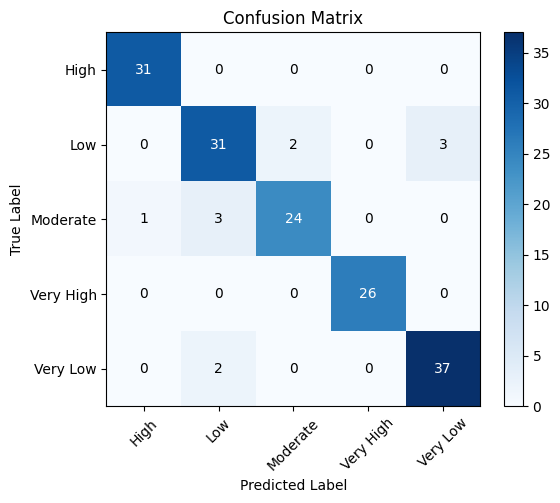

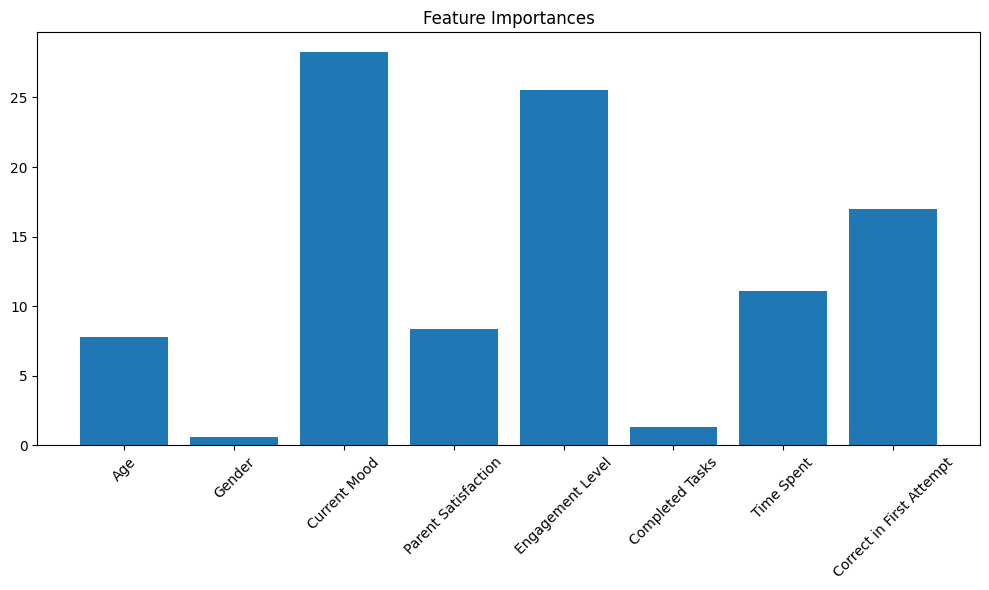

In [10]:
# Step 9: Evaluate the Model on the Test Set
# -------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nModel Accuracy on Test Set: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add readable labels
level_classes = encoders["Level"].classes_
tick_marks = np.arange(len(level_classes))
plt.xticks(tick_marks, level_classes, rotation=45)
plt.yticks(tick_marks, level_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Feature Importances
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), feature_importances, align="center")
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.tight_layout()
plt.show()

# Step 10: SHAP Explainability

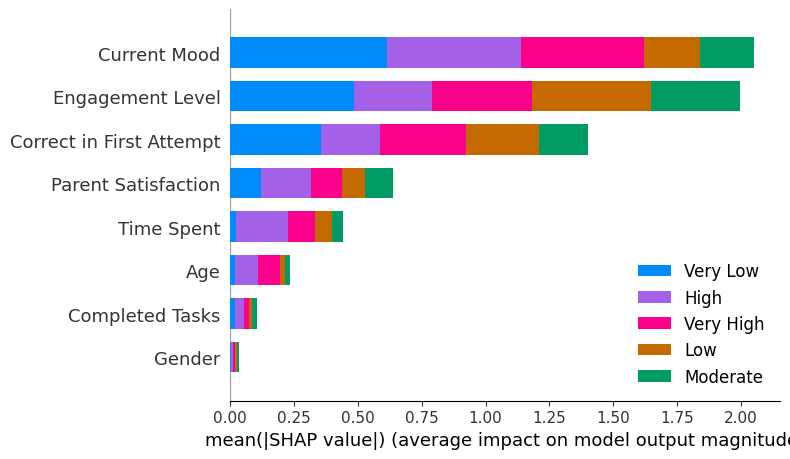

In [13]:
# Step 10: SHAP Explainability
# -------------------------------
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=level_classes)

# Step 11: Save the model and encoders

In [14]:
# Step 11: Save the model and encoders
# -------------------------------
import joblib

# Save the model
model.save_model('autism_behavior_catboost_model.cbm')

# Save the encoders
joblib.dump(encoders, 'autism_behavior_encoders.pkl')

print("\nModel and encoders saved successfully!")


Model and encoders saved successfully!


# Step 12: Test with Sample Data

In [21]:
# Step 12: Test with Sample Data
# -------------------------------
# Create sample test data (similar structure to training data)
sample_data = {
    "Age": [7, 8, 9],
    "Gender": ["Female", "Male", "Female"],
    "Current Mood": ["Happy", "Neutral", "Sad"],
    "Parent Satisfaction": [4, 5, 2],
    "Engagement Level": [25, 230, 15],
    "Completed Tasks": [8, 6, 4],
    "Time Spent": [85.2, 62.7, 45.3],
    "Correct in First Attempt": [6, 10, 3]
}

sample_df = pd.DataFrame(sample_data)

# Preprocess the sample data (same encoding as training)
for col in ["Gender", "Current Mood"]:
    sample_df[col] = encoders[col].transform(sample_df[col])

# Make predictions
sample_predictions = model.predict(sample_df)
sample_probabilities = model.predict_proba(sample_df)

# Convert numeric predictions back to original labels
predicted_levels = encoders["Level"].inverse_transform(sample_predictions.ravel())

# Create a results dataframe
results = sample_df.copy()
results["Predicted Level"] = predicted_levels

# Add probabilities for each class
for i, level in enumerate(level_classes):
    results[f"Prob_{level}"] = sample_probabilities[:, i]

print("\nSample Test Data Predictions:")
print(results[["Age", "Gender", "Current Mood", "Predicted Level"]].head())

# Detailed prediction explanation for first sample
print("\nDetailed prediction explanation for first sample:")
first_sample = sample_df.iloc[0:1]
first_sample_pred = model.predict(first_sample)
first_sample_prob = model.predict_proba(first_sample)

print("\nInput features:")
print(first_sample)

print("\nPredicted Level:", encoders["Level"].inverse_transform(first_sample_pred)[0])
print("\nClass probabilities:")
for level, prob in zip(level_classes, first_sample_prob[0]):
    print(f"{level}: {prob:.4f}")


Sample Test Data Predictions:
   Age  Gender  Current Mood Predicted Level
0    7       0             4             Low
1    8       1             5            High
2    9       0             6             Low

Detailed prediction explanation for first sample:

Input features:
   Age  Gender  Current Mood  Parent Satisfaction  Engagement Level  \
0    7       0             4                    4                25   

   Completed Tasks  Time Spent  Correct in First Attempt  
0                8        85.2                         6  

Predicted Level: Low

Class probabilities:
High: 0.0596
Low: 0.5882
Moderate: 0.2168
Very High: 0.0589
Very Low: 0.0764


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
